# Predicting reddit comment karma | Web mining 

## Part I | Feature Engineering

### Ankita BHATTACHARYA
##### M2, Statistics & Econometrics, TSE

The goal of this term project is to predict the score or **ups** of a reddit comment. In this first notebook, we shall be using text (notably Soft Clustering) and network mining methods to choose our features that will go into predicting the **ups** in the second notebook of this series. 

The first notebook contains the detailed methods of feature generation. After performing a brief exploratory analysis we extract three types of features : 
- Content-based features
    - Features based on the comments  : stylometric characteristics
        1. Length of the comment in words
        2. Count words beginning with capital letters
        3. Count number of exclamations
        4. Question marks
        5. Punctuation count
        6. Number of 'I's used in the comment
        7. Number of urls
        8. Associated subreddits
    - I added these two features to improve the model:
        9. Lexical Diversity
        10. Number of times comment references another comment
 
 
- Text mining using soft clustering : LDA, 20 features
        
- Time based features
   1. Time difference between OP and other comments
   2. Hour of the comment
   3. Day of the comment
   4. Time between the OP's first comment & the others by thread

- Network based features :Structural characteristics
   1. Reply to first comment : Earlier comments get more traction, and so do the replies to these comments 
   2. Thread popularity : calculating the length of the thread, or the number of unique authors in the link id

**Comment-Comment features : How responding to which comment gives you a bigger score**
   3. Comment depth : Calculating the comments made in response to a thread
   4. Number of neighbours : Calculating the neighbours for each thread

**Author-Author features : Interaction between users and its impact on the score**
  5. Degree centrality
  6. Betweenness centrality
  7. Eigenvector centrality 

8. Score by parent_id :Obtaining the score of comments by the parent_id or the score of the post to which the comments are a reply to.
9. Number of comments made by author


**Kernel : Python 3**

## Outline

- Loading requisite libraries 
- Data Importation
- Exploratory analysis of the data
- Feature engineering
- Text Mining
    - Preprocessing
    - Soft Clustering : Latent Dirichlet Allocation (TF matrix)
- Network Mining
    - Creating links 
    - Calculating measures of centrality
- Calculating time based features


## Loading requisite libraries

In [1]:
# ! pip install ntlk

In [2]:
# Universal
import re
import string
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
import numpy as np
import math
from collections import Counter
from datetime import datetime
import gc 

# Text mining
import nltk
from nltk import Text
from nltk import tokenize
from nltk.tokenize import word_tokenize  
from nltk.tokenize import sent_tokenize 
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from autocorrect import Speller

# Term Document Matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

# Exporting results into pickle
import pickle

# Network mining
import networkx as nx

## Importing the data
The data comments.csv must be stored in the same directory as the notebook

Data definition :
- created_utc: The time of creation in UTC epoch-second format. 
- ups: The score or upvotes-downvotes received by the comment.  
- subreddit_id: Here we only see comments coming from AskReddit
- link_id: ID of the link this comment is in
- name: Fullname of comment, e.g.\t1_c3v7f8u"
- subreddit: Name of the subreddit
- id: The ID of each comment 
- author: The reddit name of the poster
- body: The raw comment as posted on reddit
- parent_id: ID of the thing this comment is a reply to, either the link or comment in it


In [3]:
data = pd.read_csv("comments_students.csv") 
print(data.shape)


(4234970, 10)


In [4]:
# Preview the first 5 lines of the loaded data 
data.head()

,created_utc,ups,subreddit_id,link_id,name,subreddit,id,author,body,parent_id
0,1430438400,3.0,t5_2qh1i,t3_34f9rh,t1_cqug90j,AskReddit,cqug90j,jesse9o3,No one has a European accent either because i...,t1_cqug2sr
1,1430438400,3.0,t5_2qh1i,t3_34fvry,t1_cqug90k,AskReddit,cqug90k,beltfedshooter,That the kid ..reminds me of Kevin. so sad :-(,t3_34fvry
2,1430438400,5.0,t5_2qh1i,t3_34ffo5,t1_cqug90z,AskReddit,cqug90z,InterimFatGuy,NSFL,t1_cqu80zb
3,1430438401,1.0,t5_2qh1i,t3_34aqsn,t1_cqug91c,AskReddit,cqug91c,JuanTutrego,I'm a guy and I had no idea this was a thing g...,t1_cqtdj4m
4,1430438401,101.0,t5_2qh1i,t3_34f9rh,t1_cqug91e,AskReddit,cqug91e,dcblackbelt,"Mid twenties male rocking skinny jeans/pants, ...",t1_cquc4rc


## Exploratory Analysis

### Checking for missing values
We see that 24% of the dataset has missing upvotes  - this will constitute our test set

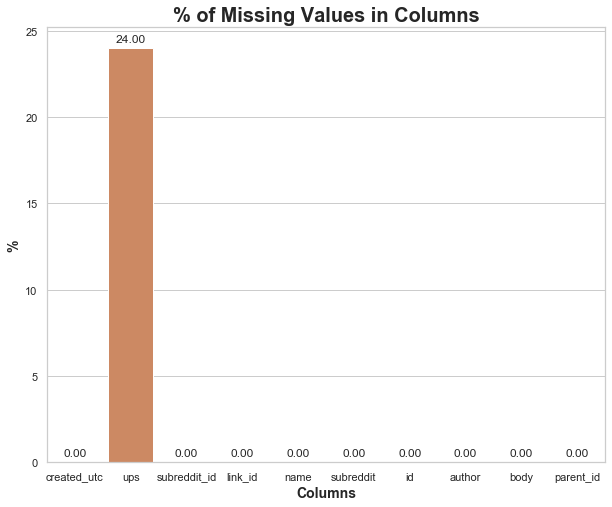

In [5]:
# Inspored by : Twitter Sentiment analysis, Kurtis Pykes. 
# github : https://github.com/kurtispykes/twitter-sentiment-analysis/blob/master/notebook/03_kpy_data_exploration.ipynb


# Visualising the missing values % 
missing_values = dict(zip([col for col in data.columns if col != "label"],
                          [round(100*data[col].isnull().sum()/len(data), 2) for col in data.columns
                           if col != "label"]))
missing_values_df = pd.DataFrame(missing_values, index=[0])
missing_values_df = missing_values_df.melt(var_name= "columns", value_name= "percentage")

# plotting missing values chart
plt.figure(figsize=(10, 8))
sns.set(style="whitegrid", color_codes=True)
seaborn_plot = sns.barplot(x="columns", y="percentage", data=missing_values_df)
for p in seaborn_plot.patches:
    seaborn_plot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center',
                   va = 'center', xytext = (0, 9), textcoords = 'offset points')
plt.title("% of Missing Values in Columns", size=20, weight="bold")
plt.xlabel("Columns", size=14, weight="bold")
plt.ylabel("%", size=14, weight="bold")
plt.show()

### Splitting into train and test sets
We perform the data cleaning on the training set from hereon

In [8]:
train_df = data[data['ups'].notnull()]
train_df.head()

,created_utc,ups,subreddit_id,link_id,name,subreddit,id,author,body,parent_id
0,1430438400,3.0,t5_2qh1i,t3_34f9rh,t1_cqug90j,AskReddit,cqug90j,jesse9o3,No one has a European accent either because i...,t1_cqug2sr
1,1430438400,3.0,t5_2qh1i,t3_34fvry,t1_cqug90k,AskReddit,cqug90k,beltfedshooter,That the kid ..reminds me of Kevin. so sad :-(,t3_34fvry
2,1430438400,5.0,t5_2qh1i,t3_34ffo5,t1_cqug90z,AskReddit,cqug90z,InterimFatGuy,NSFL,t1_cqu80zb
3,1430438401,1.0,t5_2qh1i,t3_34aqsn,t1_cqug91c,AskReddit,cqug91c,JuanTutrego,I'm a guy and I had no idea this was a thing g...,t1_cqtdj4m
4,1430438401,101.0,t5_2qh1i,t3_34f9rh,t1_cqug91e,AskReddit,cqug91e,dcblackbelt,"Mid twenties male rocking skinny jeans/pants, ...",t1_cquc4rc


In [9]:
test_df = data[data['ups'].isnull()]
test_df.head()

,created_utc,ups,subreddit_id,link_id,name,subreddit,id,author,body,parent_id
3218512,1432512001,NaN,t5_2qh1i,t3_37566r,t1_crjs2zv,AskReddit,crjs2zv,Jakeable,"Hi DE04435, your submission has been removed f...",t3_37566r
3218513,1432512001,NaN,t5_2qh1i,t3_3754y5,t1_crjs2zx,AskReddit,crjs2zx,icameforthecookies,Fancí,t3_3754y5
3218514,1432512003,NaN,t5_2qh1i,t3_374uoa,t1_crjs30r,AskReddit,crjs30r,thebattlefish,And where can I get some of these hand panties?,t1_crjpooq
3218515,1432512003,NaN,t5_2qh1i,t3_37573q,t1_crjs312,AskReddit,crjs312,stephenjash,"Join the military. I have a successful career,...",t3_37573q
3218516,1432512004,NaN,t5_2qh1i,t3_3735sz,t1_crjs31m,AskReddit,crjs31m,MoorgunFreeman,The most horrifying thing I've seen in this th...,t1_crjao8x


### Further cleaning - Training Set
Comments on reddit that have already been removed do not contribute to prediction. We shall remove those that say "removed". This is only on the training set as all the data needs to be preserved for the test set (Kaggle)

In [10]:
len_tot = len(train_df)
train_df = train_df[train_df.body != '']
train_df = train_df[train_df.body != '[removed]']
train_df.reset_index(inplace=True, drop=True)

In [11]:
# Reconcatenating
df = pd.concat([train_df, test_df], ignore_index=True)
df.shape

(4234958, 10)

Checking the datatypes of the df dataset. We will need to convert 'body' from object to string 

In [ ]:
df.dtypes

In [12]:
df['body'] = df['body'].astype('str')

## Feature Engineering

### A. Content based features

1. Length of the comment in words : studying the relationship between comment length and upvotes/downvotes

In [13]:
df['num_words'] = df.body.apply(lambda x: len(str(x).split()))

Features A.2 to A.5 will extract features relating to a common question in text mining : Is punctuation important ? 

2. Count words beginning with capital letters :  

In [14]:
df['words_caps'] = df.body.apply(lambda x: len(re.findall(r'[A-Z]', str(x))))

3. Count number of exclamations

In [15]:
df['num_exclamation_marks'] = df['body'].str.count('!')

4. Question marks

In [16]:
df['num_question_marks'] = df['body'].str.count("\?")

5. Count punctuations

In [17]:
df['num_punctuation'] = df['body'].str.count(".|,|;|'|:")

6. Number of I's : How important is subjectivity to upvotes ? 

In [18]:
df['num_subject'] = df['body'].str.count("I|I've|I'm|I'd|i've|i'm|i'd| i ")

7. Count the number of urls

In [19]:
url = r'(https?://\S+)'
df['urlcount'] = df.body.apply(lambda x: re.findall(url, str(x))).str.len()

8. Associated sub reddits

In [20]:
df['sub_reddits'] = df.body.apply(lambda x: len(re.findall(r"/r/([^\s/]+)", str(x)))) 

9. Lexical diversity
Ref :  O'Reilly 'Natural Language Processing and Python, page 9

In [21]:
def lexical_diversity(text):
     return len(set(text)) / len(text) if len(text) !=0 else 0
    
# df['lexicalDiversity'] = df['body'].apply(lexical_diversity)
df['lexicalDiversity'] = [lexical_diversity(text) for text in df['body']]

10. Referencing

In [22]:
# Check for '&gt;'
df['is_referencing'] = df.body.str.contains('&gt;').astype(int) 
# We should also remove this reference 
df['body'] = df.body.apply(lambda x: str(x).replace('&gt;', ''))


Let us look at these content based features

In [147]:
df.head()

,created_utc,ups,subreddit_id,link_id,name,subreddit,id,author,body,parent_id,...,thread_pop,comment_depth,count_nb,parent_score,nb_com_author,degree_centrality,betweenness_centrality,eigenvector_centrality,is_referencing,lexicalDiversity
0,1430438400,3.0,t5_2qh1i,t3_34f9rh,t1_cqug90j,AskReddit,cqug90j,jesse9o3,No one has a European accent either because i...,t1_cqug2sr,...,2786,1,1,10.0,54,0.000141,0.000023,1.358437e-04,0,0.193277
1,1430438400,3.0,t5_2qh1i,t3_34fvry,t1_cqug90k,AskReddit,cqug90k,beltfedshooter,That the kid ..reminds me of Kevin. so sad :-(,t3_34fvry,...,12349,1,1,10.0,5,0.000007,0.000000,1.249299e-08,0,0.437500
2,1430438400,5.0,t5_2qh1i,t3_34ffo5,t1_cqug90z,AskReddit,cqug90z,InterimFatGuy,NSFL,t1_cqu80zb,...,7247,1,1,10.0,57,0.000160,0.000040,4.572286e-05,0,1.000000
3,1430438401,1.0,t5_2qh1i,t3_34aqsn,t1_cqug91c,AskReddit,cqug91c,JuanTutrego,I'm a guy and I had no idea this was a thing g...,t1_cqtdj4m,...,1466,1,1,10.0,5,0.000000,0.000000,0.000000e+00,0,0.333333
4,1430438401,101.0,t5_2qh1i,t3_34f9rh,t1_cqug91e,AskReddit,cqug91e,dcblackbelt,"Mid twenties male rocking skinny jeans/pants, ...",t1_cquc4rc,...,2786,1,2,10.0,2,0.000005,0.000000,2.880685e-08,0,0.132780


## Text Mining : Preprocessing 

Our corpus is massive and to reduce the time for pre-processing, we ought to remove punctuations, special characters and single letters. The idea is therefore to pre-process the data which will then be fed to the vectorizer function. 
The pre-processing shall include the following steps 

- Cleaning the text : converting to lower text, removing the punctuations, URLS, special characters etc. 
- Tokenization
- Removing the stop words
- Stemming : Eliminating affixes (circumfixes, suffixes, prefixes, infixes) from a word in order to obtain a word stem. 

In [41]:
# Let us first remove the stop words
stop_words = stopwords.words('english')
# Removing the subreddit sign
stop_words.extend(["\r"])
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [47]:
def preprocess_text(text):
    # Converting to lower case
    text.lower()
    # Remove urls
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    # Remove user @ references and '#' from text
    text = re.sub(r'\@\w+|\#','', text)
    # Remove punctuations
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove all single characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    # Remove single characters from the start
    text = re.sub(r'\^[a-zA-Z]\s+', ' ', text)
    # Remove characters of 3 characters
    text = re.sub(r'\b\w{1,3}\b', '', text)
    # Tokenizing the corpus
    text_tokens = word_tokenize(text)
    # Remove stopwords
    filtered_words = [w for w in text_tokens if not w in stop_words]
    # Stemming the corpus
    ps = PorterStemmer()
    stemmed_words = [ps.stem(w) for w in filtered_words]
    
    return " ".join(stemmed_words)

In [48]:
text_preprocessed = df['body'].apply(preprocess_text)

In [64]:
text_preprocessed[0]

'european accent either doesnt exist there accent europ european accent'

We see that there are some  spelling errors and inspired by https://rustyonrampage.github.io/text-mining/2017/11/28/spelling-correction-with-python-and-nltk.html I implemented the spelling correction. The idea is first to shorten words like reallllly into really. This however might not be sufficient in correcting all words. We shall then implement the spellchecker using **Speller** from the **autocorrect** library 

In [84]:
def reduce_lengthening(text):
    pattern = re.compile(r"(.)\1{2,}")
    reduced = pattern.sub(r"\1\1", text)
    return "".join(reduced)

reduce_lengthening("reallllllly")

'really'

In [97]:
pattern = re.compile(r"(.)\1{2,}")
red_text = [pattern.sub(r"\1\1", text) for text in text_preprocessed]

In [ ]:
# I tried the spellchecker using parallel processing, but it took too long and my computer hung several times. 
# spell = Speller(lang = 'en')
# final_preprocessed = [spell(text) for text in red_text]

In [2]:
with open('preprocessed.pkl', 'rb') as f:
    text_preprocessed = pickle.load(f)

### B. Soft Clustering :  Features extracted using LDA

Building the term frequency which shall be applied on the LDA model : 
* Here we remove words that appear in over 20% of the comments
* Remove words appearing in less than 20 comments
* The maximum number of words kept per comment are 25.
* Keep words having more than 3 characters

In [3]:
print("Extracting the tf features for LDA matrix ...")
tf_vectorizer = CountVectorizer(max_df = 0.5, min_df = 20,
                                max_features = 20, 
                                token_pattern='[a-zA-Z0-9]{3,}', # char count >3
                                stop_words = 'english')

tf = tf_vectorizer.fit_transform(text_preprocessed)
print("Proceed to next cell.")

Extracting the tf features for LDA matrix ...
Proceed to next cell.


In [4]:
lda = LatentDirichletAllocation(n_components = 20, 
                                learning_method = "batch").fit(tf)
# Topic-word matrix
print(lda.components_)

[[4.00000000e-02 1.63999250e-01 4.00000000e-02 4.00000000e-02
  4.00000000e-02 4.00000000e-02 4.00000000e-02 5.03955507e+05
  4.00000000e-02 4.02253499e-02 4.00000000e-02 1.56696544e-01
  4.00000000e-02 4.00000000e-02 4.00000000e-02 4.00000000e-02
  4.00000000e-02 4.00000000e-02 4.00000000e-02 4.00000000e-02
  4.11376298e-02 4.00000079e-02 4.18130524e-02 4.00000000e-02
  4.00000000e-02]
 [4.00000000e-02 1.34057119e-01 4.00000000e-02 4.00000000e-02
  4.00000000e-02 2.15304064e-01 4.12788646e-02 7.30530063e+00
  4.00000000e-02 8.02167641e-02 4.00025437e-02 4.00000854e-02
  4.00000000e-02 4.00000000e-02 4.00000000e-02 4.00000000e-02
  1.51136479e-01 4.00000000e-02 4.00375946e-02 4.11702057e-02
  4.00000000e-02 2.44213552e+01 1.44513585e-01 2.48349221e+01
  2.06708615e+05]
 [4.00000000e-02 4.00980767e-02 4.00000000e-02 4.00000000e-02
  1.52652239e+05 4.00000000e-02 4.00000378e-02 4.10777515e-02
  4.00000000e-02 4.00000000e-02 4.00000000e-02 4.00001728e-02
  4.00000000e-02 4.00000000e-02 4.

I will be saving these features extracted using LDA into a pickle as they are not required for the network mining part to follow

In [23]:
df_1 = pd.DataFrame(lda.components_, columns=tf_vectorizer.get_feature_names())
final_tokenized = pd.concat([df, df_1], axis=1)
final_tokenized.head()

,created_utc,ups,subreddit_id,link_id,name,subreddit,id,author,body,parent_id,...,question,realli,someth,thi,thing,think,time,want,work,year
0,1430438400,3.0,t5_2qh1i,t3_34f9rh,t1_cqug90j,AskReddit,cqug90j,jesse9o3,No one has a European accent either because i...,t1_cqug2sr,...,0.04,0.040000,0.040000,0.040000,0.040000,0.041138,0.040000,0.041813,0.040000,0.040000
1,1430438400,3.0,t5_2qh1i,t3_34fvry,t1_cqug90k,AskReddit,cqug90k,beltfedshooter,That the kid ..reminds me of Kevin. so sad :-(,t3_34fvry,...,0.04,0.151136,0.040000,0.040038,0.041170,0.040000,24.421355,0.144514,24.834922,206708.614654
2,1430438400,5.0,t5_2qh1i,t3_34ffo5,t1_cqug90z,AskReddit,cqug90z,InterimFatGuy,NSFL,t1_cqu80zb,...,0.04,0.040000,0.040000,107364.016426,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000
3,1430438401,1.0,t5_2qh1i,t3_34aqsn,t1_cqug91c,AskReddit,cqug91c,JuanTutrego,I'm a guy and I had no idea this was a thing g...,t1_cqtdj4m,...,0.04,0.237241,0.485557,0.040000,0.284080,0.388071,8311.343145,11712.427669,0.085683,10.473797
4,1430438401,101.0,t5_2qh1i,t3_34f9rh,t1_cqug91e,AskReddit,cqug91e,dcblackbelt,"Mid twenties male rocking skinny jeans/pants, ...",t1_cquc4rc,...,0.04,0.040050,0.040000,0.040000,0.040303,0.040000,0.055661,0.370109,0.040000,0.040000


In [24]:
# text_preprocessed.to_pickle("preprocessed.pkl")
final_tokenized.to_pickle("lda_features.pkl")

#### Removing variables we will not need 

In [118]:
del text_preprocessed
del final_tokenized
del data
gc.collect()

149

### B. Time based features

Let us first convert unix timestamp to datetime format in seconds

In [119]:
# Convert created_utc to datetime
df['time_convert'] = pd.to_datetime(df.created_utc, unit='s')

Defining a function that would give us a dictionary containing the keys and the value. 

In [121]:
def extract_dict(dic, x):
    try:
        return dic[x]
    except:
        return np.nan

1. Time since OP in seconds

In [122]:
# Obtaining time of each comment
comment_timing = pd.Series(df.time_convert.values, index = df.name).to_dict()
df['time_diff_parent'] = df.parent_id.apply(lambda x: extract_dict(comment_timing, x))
# Those that do not have a time, we assign them the publication time of the OP
df.loc[df.time_diff_parent.isna(), 'time_since_parent'] = df.time_convert
# Calculating the difference between the times
df.time_diff_parent = df.time_convert - df.time_diff_parent
df.time_diff_parent = df.time_diff_parent.apply(lambda x: x.total_seconds())
del comment_timing

2. Hour of the comment

In [124]:
# Finding hour of the comment
df['hour_of_comment'] = df.time_convert.apply(lambda x: x.hour)

3. Day of the comment

In [125]:
# Day of the comment
df['day_of_comment'] = df.time_convert.dt.weekday

4. Time_between_comments : Time between the OP's first comment and other comments in thread in seconds

In [127]:
# Creating a dictionary with publication times for the first comment by thread.
df_time_first_comment = df[['link_id', 'time_convert']].groupby(by=['link_id']).min().to_dict('index') 
# Time difference between the OP's first comment and other comments
df['time_between_comments'] = df.time_convert - df.link_id.apply(lambda x: df_time_first_comment[x]['time_convert'])
df.time_between_comments = df.time_between_comments.apply(lambda x: x.total_seconds())

##  Network Mining
### C. Network based features

1. Reply to first comment : Earlier comments get more traction, and so do the replies to these comments 
Upon noticing that comments replying to the first comment to the post start with t3, we create the feature rep_first

In [128]:
df['rep_first'] = df.parent_id.str.startswith('t3_').astype(int)

2. Thread popularity : calculating the length of the thread, or the number of unique authors in the link id

In [129]:
auth_unique = pd.Series(df.author.values, index=df.link_id).groupby(by=['link_id']).count().to_dict()
df['thread_pop'] = df.link_id.apply(lambda x: extract_dict(auth_unique, x))

This is where the network mining part actually starts. We need to get the depth of each thread : each comment (parent) would have its sub-comments (children). The job is to transform this into a node and edges relation.

In [130]:
G = nx.DiGraph()
# The link id can be used to generate the nodes as comments are linked through this link_id
G.add_nodes_from(df.link_id, type = "linkage")
# Now we get the comments that are linked - name is the unique name of the comment
G.add_nodes_from(df.name, type = "comment name")
# We then create the links between the comments which will ultimately give us the neighbour count
G.add_edges_from(df[["parent_id", "name"]].values, linktype = "par")


Given these characteristics, we can now get the depth of each comment and the number of neighbours or the comments attached to it

In [131]:
df['comment_depth'] = [len(nx.ancestors(G, neighbour)) for neighbour in df['name']]
df['count_nb'] = [G.degree[neighbour] for neighbour in df['name']]

3. Centrality measures
Let's now calculate the author-author interaction (undirected) : how much users interacted while commenting and how it possibly affects the score. 
To focus on the  relative importance of vertices within the network, we will calculate 3 of the 5 centrality metrics (the ones that took the shortest time to run), all implemented in networkx.

    * degree centrality
    * betweenness centrality
    * eigenvector centrality

We create two subsets
* 1. Containing the author identified by his comment. 
* 2. Containing the author and the ID of the comment being replied to (parent_id)

In [132]:
author_comment = df[['author', 'name']]
author_parent_id = df[['author', 'parent_id']]
# Je repère les noeuds à connecter
merged = author_comment.merge(author_parent_id, left_on='name', right_on='parent_id', how='inner',
                                  suffixes = ('_parent', '_child')) # On sait qui est le parent 

# Cleaning the entire merged df containing parents and children respectively
merged = merged.groupby(['author_parent', 'author_child']).aggregate({'author_child':'count'})
merged.columns = ['counts']
merged.reset_index(level=0, drop=False, inplace=True)
merged.reset_index(level=0, drop=False, inplace=True)

# Finally ! We have the nodes that need to be connected ! 
nodes_at_last = merged.values
    
# Creating the graph for the users (Undirected)
G1 = nx.Graph() # Undirected Simple type
G1.add_weighted_edges_from(nodes_at_last)
   

In [133]:
if nx.is_connected(G1) == False :
    print('The graph is not connected.')
else: 
    print('The graph is connected.')

The graph is not connected.


In [138]:
def centralities (df):
    degree_centralities = []
    betweenness_centralities = []
    eigenvector_centralities = []
  
    # Here we are getting the degree centralities
    degree_cent = nx.degree_centrality(G1)
    
    # Same for betweeness centrality
    between_cent = nx.betweenness_centrality(G1, k = 60, weight = 'weight', normalized = True)
    
    # Lastly eigenvector centralities
    eigen_cent = nx.eigenvector_centrality(G1, weight = 'weight')
    
    # Now we must append the features  
    all_nodes = G1.nodes
    # * collects all the positional arguments in a tuple
    degree_cent_mean = int(pd.Series([*degree_cent.values()]).mean())
    between_cent_mean = int(pd.Series([*between_cent.values()]).mean())
    eigen_cent_mean = int(pd.Series([*eigen_cent.values()]).mean())
    
    for i in df.author :
        if i in all_nodes:
            degree_centralities.append(degree_cent[i])
            betweenness_centralities.append(between_cent[i])
            eigenvector_centralities.append(eigen_cent[i])
            
        else:
            degree_centralities.append(degree_cent_mean)
            betweenness_centralities.append(between_cent_mean)
            eigenvector_centralities.append(eigen_cent_mean)
            
    df['degree_centrality'] = degree_centralities
    df['betweenness_centrality'] = betweenness_centralities
    df['eigenvector_centrality'] = eigenvector_centralities
    
    print("It took long... but move on")
    return(df)

In [142]:
df = centralities(df)

It took long... but move on


4. Score by parent_id

Obtaining the score of comments by the parent_id or the score of the post to which the comments are a reply to. In case comments don't have a parent, I used median imputation (more robust)

In [140]:
score_every_comment = pd.Series(df['ups'].values, index=df['name']).to_dict() # dictionary
df['parent_score'] = df.parent_id.apply(lambda x: extract_dict(score_every_comment, x))
# Median imputation
median_value = df.parent_score.median()
df.parent_score.fillna(median_value, inplace=True)

5. Number of comments made by the author 

In [141]:
author_comment_count = pd.Series(df.name.values, index=df.author).groupby(by=['author']).count().to_dict()
df['nb_com_author'] = df.author.apply(lambda x: extract_dict(author_comment_count, x))

### You have reached the end of the first notebook.
We shall export these results to be used in the second half of the project - refer to notebook 2. Prediction

In [148]:
df.to_pickle("dff.pkl")

In [149]:
gc.collect()

824129